In [6]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")

In [7]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")

In [8]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [9]:
@tool
def multiply(x:int,y:int) -> int:
    """Multiply two numbers."""
    return x*y

In [10]:
@tool
def search(query:str):
    """Search to web for query and return result"""
    tavily = TavilySearchResults(query=query,k=5)
    result=tavily.invoke(query)
    return f"Result for {query} is: \n {result}"


In [11]:
print(search({"query":"what is france's capital?"}))
print(search.invoke({"query":"what is USA's capital?"}))

/var/folders/r6/94rtxyj11sgb8st7ytmz40ph0000gn/T/ipykernel_27230/1574773611.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(search({"query":"what is france's capital?"}))


Result for what is france's capital? is: 
 [{'title': 'Paris - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Paris', 'content': 'As the capital of France, Paris is the seat of France\'s national government. For the executive, the two chief officers each have their own official residences, which also serve as their offices. The President of the French Republic resides at the Élysée Palace.( The Prime Minister\'s seat is at the Hôtel Matignon.( Government ministries are located in various parts of the city, many near the Hôtel Matignon.( [...] Appearance\n\nmove to sidebar hide\n\nCoordinates: 48°51′24″N 2°21′8″E / 48.85667°N 2.35222°E / 48.85667; 2.35222_region:FR-75C)\n\nImage 4: This is a good article. Click here for more information.\n\nImage 5: Page semi-protected\n\nFrom Wikipedia, the free encyclopedia\n\nCapital and largest city of France\n\nThis article is about the capital city of France. For other uses, see Paris (disambiguation) "Paris (disambiguation)"). [...] Paris (Fre

In [12]:
tools=[multiply,search]
tools

[StructuredTool(name='multiply', description='Multiply two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x10fc4aa20>),
 StructuredTool(name='search', description='Search to web for query and return result', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fc4bce0>)]

In [13]:
llm_with_tools=llm.bind_tools(tools=tools)

In [14]:
result=llm_with_tools.invoke("what is current GDP of india?")


In [15]:
# no content because it just tool call info
result.content

''

In [16]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of India 2023'},
  'id': '88sk69vyz',
  'type': 'tool_call'}]

In [17]:
result.tool_calls[0]['name']

'search'

In [18]:
result.tool_calls[0]['args']

{'query': 'current GDP of India 2023'}

In [19]:
tool_mapping={ tool.name:tool for tool in tools}
tool_mapping

{'multiply': StructuredTool(name='multiply', description='Multiply two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x10fc4aa20>),
 'search': StructuredTool(name='search', description='Search to web for query and return result', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fc4bce0>)}

In [20]:
result=tool_mapping['search'].invoke({"query": "important event in history today"})

In [21]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

AttributeError: 'str' object has no attribute 'tool_calls'

In [22]:
from typing import TypedDict,Sequence,Annotated
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    """State of the agent."""
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [23]:
state={"messages":['hi','hello']}

In [24]:
def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}

In [25]:
def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls) > 0:
        return "tool"
    else:
        return "end"

# eariler we were using the tool node from list of tool
# but now we have crate tool invoke(custom funtion)
# why we are doing it: as a user if we want to take a authority to which i need to give permission for execution

In [27]:
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    print(f"tool_details : {tool_details}")
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Selected tool: {tool_details[0]['name']}")

    if tool_details[0]['name'] == "search":
        response=input(prompt=f"[yes/no] do you want to continue with expensive web search")
        if response.lower() == 'no':
            print("web search discard by user, exiting gracefully.")
            raise Exception("web search discard by user")
        
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])    
    return {"messages": [response]} 


In [28]:
from langgraph.graph import StateGraph,START,END
graph = StateGraph(AgentState)

graph.add_node("ai_assistent",invoke_model)
graph.add_node("tool",invoke_tool)

graph.set_entry_point("ai_assistent")
#graph.add_edge("ai_assistent","tool")

graph.add_conditional_edges("ai_assistent",router,
                            {
                                "tool":"tool",
                                "end":END
                            })



In [29]:
app=graph.compile()

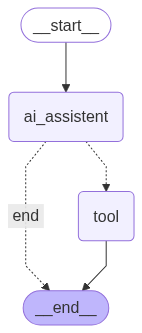

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
app.invoke({"messages": ["what is the lastest news of delhi"]})

tool_details : [{'name': 'search', 'args': {'query': 'latest news of Delhi'}, 'id': '89hpzzn0m', 'type': 'tool_call'}]
Selected tool: search


{'messages': ['what is the lastest news of delhi',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '89hpzzn0m', 'function': {'arguments': '{"query":"latest news of Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 172, 'total_tokens': 301, 'completion_time': 0.56788538, 'prompt_time': 0.010770685, 'queue_time': 0.05666982499999999, 'total_time': 0.578656065}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--85ea169e-5af9-4d61-915c-4dba390d1d3c-0', tool_calls=[{'name': 'search', 'args': {'query': 'latest news of Delhi'}, 'id': '89hpzzn0m', 'type': 'tool_call'}], usage_metadata={'input_tokens': 172, 'output_tokens': 129, 'total_tokens': 301}),
  'Result for latest news of Delhi is: \n [{\'title\': \'Live Delhi News Today 29 June 2025: - haribhoomi.com\', \'url\': \'https://www.haribhoomi.com/state-

In [ ]:
app.invoke({"messages": ["what is the lastest news of USA"]})

tool_details : [{'name': 'search', 'args': {'query': 'latest news USA'}, 'id': 'k7pqak0pz', 'type': 'tool_call'}]
Selected tool: search
web search discard by user, exiting gracefully.


Exception: web search discard by user

In [30]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [31]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node=ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'multiply': StructuredTool(name='multiply', description='Multiply two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x10fc4aa20>), 'search': StructuredTool(name='search', description='Search to web for query and return result', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fc4bce0>)}, tool_to_state_args={'multiply': {}, 'search': {}}, tool_to_store_arg={'multiply': None, 'search': None}, handle_tool_errors=True, messages_key='messages')

In [32]:
def ai_assitent(state:AgentState):
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

In [37]:
graph_react=StateGraph(AgentState)

graph_react.add_node("ai_assitent",ai_assitent)

graph_react.add_node("tools",tool_node)

graph_react.set_entry_point("ai_assitent")

graph_react.add_conditional_edges("ai_assitent",tools_condition)

graph_react.add_edge("tools","ai_assitent")





In [38]:
app_react=graph_react.compile(checkpointer=memory,interrupt_before=["tools"])

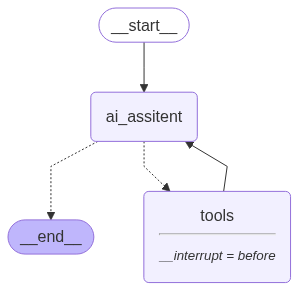

In [39]:
from IPython.display import Image, display
display(Image(app_react.get_graph(xray=True).draw_mermaid_png()))

In [40]:
config={"configurable":{"thread_id":"1"}}

In [41]:
from langchain_core.messages import HumanMessage,AIMessage
response=app_react.invoke({"messages":[HumanMessage("what is the cap of india?")]},config=config)
#app_react.invoke({"messages":["what is the cap of india?"]},config=config)

In [42]:
response

{'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545})]}

{'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545})]}

In [43]:
snapshot=app_react.get_state(config=config)

In [44]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f

StateSnapshot(values={'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f054a85-f57a-6dd4-8001-b7cff9cd37b8'}}, metadata={'source': 'loop', 'writes': {'ai_assitent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545})]}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-29T05:17:37.930582+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f054a85-e51f-605c-8000-42abd2bfcb24'}}, tasks=(PregelTask(id='88220a44-ada3-9718-f4f6-2f046e7496ef', name='tools', path=('__pregel_pull', 'tools'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [45]:
snapshot.next

('tools',)

In [46]:
last_message=snapshot.values["messages"][-1]

In [47]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545})

In [48]:
app_react.invoke(None,config=config)

{'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545}),
  ToolMessage(content='Result for cap of India is: \n [{\'title\': \'Buy Indian Flag Cap Online- Royal Blue Unisex Cap [Ro

In [60]:
tool_details=last_message.tool_calls

In [61]:
tool_details

[{'name': 'search',
  'args': {'query': 'cap of India'},
  'id': 'q02rnvetd',
  'type': 'tool_call'}]

In [62]:
tool_details[0]['name']

'search'

In [63]:
if tool_details[0]["name"]== "search":
    user_input=input(prompt=f"[yes/no] do you want to continue with {tool_details[0]['name']}?").lower()
    if user_input=="no":
        print("web tool discarded")
        raise Exception("Web tool discarded by the user.")
    else:
        response=app_react.invoke(None,config)
        print(response)
else:
    response=app_react.invoke(None,config)
    print(response)

{'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545}), ToolMessage(content='Result for cap of India is: \n [{\'title\': \'Buy Indian Flag Cap Online- Royal Blue Unisex Cap [Round 

In [64]:
response=app_react.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

In [65]:
response

{'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545}),
  ToolMessage(content='Result for cap of India is: \n [{\'title\': \'Buy Indian Flag Cap Online- Royal Blue Unisex Cap [Ro

In [66]:
tool_call_id=last_message.tool_calls[0]["id"]

In [67]:
tool_call_id

'q02rnvetd'

In [68]:
from langchain_core.messages import AIMessage,ToolMessage

In [69]:
new_message=[
    ToolMessage(content="according to the latest data 4.1 trillion USD",tool_call_id=tool_call_id),
    AIMessage(content="GDP is 4.1 Trillion USD.")
    
]

In [70]:
app_react.update_state(config, 
                  {
                      "messages":new_message
                   }
                  )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f054af6-46ee-6808-8007-2dadf1082d3f'}}

In [71]:
app_react.get_state(config).values["messages"][-1]

AIMessage(content='GDP is 4.1 Trillion USD.', additional_kwargs={}, response_metadata={})

In [73]:
app_react.invoke(None,config=config)

{'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545}),
  ToolMessage(content='Result for cap of India is: \n [{\'title\': \'Buy Indian Flag Cap Online- Royal Blue Unisex Cap [Ro

In [75]:
response=app_react.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

In [76]:
response

{'messages': [HumanMessage(content='what is the cap of india?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q02rnvetd', 'function': {'arguments': '{"query":"cap of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 375, 'prompt_tokens': 170, 'total_tokens': 545, 'completion_time': 1.521251479, 'prompt_time': 0.010649224, 'queue_time': 0.054385896, 'total_time': 1.531900703}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d07b2d69-aea4-4193-8f29-e56db4c23622-0', tool_calls=[{'name': 'search', 'args': {'query': 'cap of India'}, 'id': 'q02rnvetd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 375, 'total_tokens': 545}),
  ToolMessage(content='Result for cap of India is: \n [{\'title\': \'Buy Indian Flag Cap Online- Royal Blue Unisex Cap [Ro